In [37]:
# Import what we need for the job...
import keras
import numpy             as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_tqdm                 import TQDMNotebookCallback
# Visualization
from IPython.display            import SVG
from IPython.display            import display
from keras.utils.vis_utils      import model_to_dot

# Problem 1

In [38]:
with open('/home/share/gutenberg_example/PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

text = []
for i in range(len(lines)):
    if lines[i] != '':
        text = text + [lines[i]]
min_length = max([len(i) for i in text])

In [39]:
# Unique characters - precalculated
with open('/home/share/gutenberg_example/unique_chars.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
# Integer code to symbol
itos = ['','',' ']
for i in lines:
    itos = itos + [i]
    # Symbol to integer code
    stoi = dict()
    stoi['STOP'] = 0
    stoi['START'] = 1
for i in range(2,len(itos)):
    stoi[itos[i]] = i

In [40]:
def encode_seq(x,mapping,min_length=0):
    # String to one-hot
    y = [mapping['START']]
    for i in list(x):
        y = y + [mapping[i]]
    y = y + [mapping['STOP']]
    # Stop-padding - handled elsewhere...
    while len(y) < min_length:
        y = y + [mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))
def decode_seq(x,mapping):
    # One-hot to string
    y = []
    for i in x:
        y = y + [mapping[np.argmax(i)]]
    return ''.join(y)

In [41]:
# Encode that data
dataX = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:] = temp

dataY = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:] = temp


In [42]:
X = dataX[0:dataX.shape[0]-1,:,:]
Y = dataY[1:dataY.shape[0],:,:]
preY = Y[:,0:Y.shape[1]-1,:]
postY = Y[:,1:Y.shape[1],:]

In [43]:
nlines = 50
X = X[0:nlines,:,:]
Y = Y[0:nlines,:,:]
preY = preY[0:nlines,:,:]
postY = postY[0:nlines,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(50, 76, 71)
(50, 76, 71)
(50, 75, 71)
(50, 75, 71)


In [44]:
# Your model here!

hidden_size                                             = 3*(max(len(i) for i in text)+2)

#Encoder design.
encoder_input                                           = keras.layers.Input(shape = (None, X.shape[2]))
encoder_hidden                                          = keras.layers.LSTM(hidden_size,
                                                                            return_state = True)

# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)

encoder_states                                          = [enc_state_h, enc_state_c]

## Decoder Design
# Set up the decoder, using `encoder_states` as initial state.
decoder_input                                           = keras.layers.Input(shape = (None, preY.shape[2]))
decoder_hidden                                          = keras.layers.LSTM(hidden_size,
                                                                            return_sequences = True,
                                                                            return_state     = True)

# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                         initial_state = encoder_states)

decoder_dense                                           = keras.layers.Dense(postY.shape[2],
                                                                             activation = 'softmax')
# Connect output to hidden
decoder_output                                          = decoder_dense(decoder_hidden_output)

# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model                                                   = keras.Model([encoder_input, decoder_input],
                                                                      decoder_output)

In [45]:
# Compile it...
model.compile(loss      = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics   = ['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, None, 71)     0                                            
__________________________________________________________________________________________________
lstm_59 (LSTM)                  [(None, 228), (None, 273600      input_45[0][0]                   
__________________________________________________________________________________________________
lstm_60 (LSTM)                  [(None, None, 228),  273600      input_46[0][0]                   
                                                                 lstm_59[0][1]                    
          

In [46]:
batch_size = nlines # number of patterns...
epochs     = 1500
history    = model.fit([X,preY],
                       postY,
                       batch_size = batch_size,
                       epochs     = epochs,
                       verbose    = 0,
                       callbacks  = [TQDMNotebookCallback()])

HBox(children=(IntProgress(value=0, description='Training', max=1500), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=50), HTML(value='')))

In [47]:
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

50/50 [==============================] - 2s 33ms/step
Accuracy: 82.1066651344 %


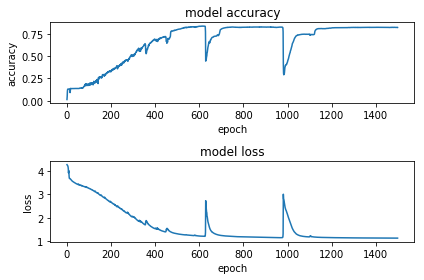

In [48]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [49]:
#Your encoder_model and decoder_model here!
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model                                           = keras.Model(encoder_input,
                                                                      encoder_states)

# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h                                   = keras.layers.Input(shape = (hidden_size,))
decoder_state_input_c                                   = keras.layers.Input(shape = (hidden_size,))

# Connect hidden to input(s)
decoder_states_input                                    = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                         initial_state = decoder_states_input)
decoder_states                                          = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output                                          = decoder_dense(decoder_hidden_output)
decoder_model                                           = keras.Model([decoder_input]  + decoder_states_input,
                                                                      [decoder_output] + decoder_states)

In [50]:
# Get the gestalt context for the input sequence(s)
i       = 0
context = encoder_model.predict(X[i:i+1,:,:])
# Prep a starting token...
token   = encode_seq('',stoi)[0].reshape(1,1,len(stoi))

In [51]:
# What should we see?
print('Input:', text[i])
print('Output:', text[i+1])

Input: It is a truth universally acknowledged, that a single man in possession
Output: of a good fortune, must be in want of a wife.


In [52]:
# Complete max cycles with the decoder
result = np.zeros([1,postY.shape[1],postY.shape[2]])
for x in range(postY.shape[1]):
    out,h,c = decoder_model.predict([token]+context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
decode_seq(result[0,:,:],itos)

'of a good fortune, must be in want of a wife.'

In [53]:
# Iterate - teacher forcing through each line
for i in range(nlines):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[i:i+1,:,:])
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))

Txt: of a good fortune, must be in want of a wife.
Net: of a good fortune, must be in want of a wife.
Txt: However little known the feelings or views of such a man may be on his
Net: However little known the feelings or views of such a man may be on his
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: first entering a neighbourhood, this truth is so well fixed in the minds
Txt: of the surrounding families, that he is considered the rightful property
Net: of the surrounding families, that he is considered the rightful property
Txt: of some one or other of their daughters.
Net: of some one or other of their daughters.
Txt: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Net: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Txt: Netherfield Park is let at last?"
Net:  note and theing of higerry.
Txt: Mr. Bennet replied that he had not.
Net: Mr. Bennet replied that he had not.
Txt: "But it is," returned she;

In [54]:
# Iterate - but no teacher forcing past first line...
# Get the gestalt context for the input sequence
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
for i in range(nlines):
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context = encoder_model.predict(result)

Txt: of a good fortune, must be in want of a wife.
Net: of a good fortune, must be in want of a wife.
Txt: However little known the feelings or views of such a man may be on his
Net: However little known the feelings or views of such a man may bo on his
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: first entering a neighbourhood, this truth is so well fixed in the minds
Txt: of the surrounding families, that he is considered the rightful property
Net: " is hive oto be hou od tae Mn. Bingly wil in ee varys then to
Txt: of some one or other of their daughters.
Net: "But os it asit ee ered o thes Mro inelire, an tat ethem.
Txt: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Net: ow no Mondey i ou e dod of te see he ,, ar o as ftthm
Txt: Netherfield Park is let at last?"
Net: nmered tha  eamtnkn
Txt: Mr. Bennet replied that he had not.
Net: "Wha y heamn ar us nege s anet any wan a  hesins
Txt: "But it is," returned she; "for Mr

# Problem 2

In [2]:
# Preprocessing - grab lines from the file
with open('/home/share/gutenberg_example/PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
# Paragraphs are separated by blank
# lines -> just drop those lines...
text = []
for i in range(len(lines)):
    if lines[i] != '':
        text = text + [lines[i]]
#min_length = max([len(i) for i in text])

In [3]:
# Unique characters - precalculated
with open('/home/share/gutenberg_example/unique_chars.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
# Integer code to symbol
itos = ['','',' ']
for i in lines:
    itos = itos + [i]
    # Symbol to integer code
    stoi = dict()
    stoi['STOP'] = 0
    stoi['START'] = 1
for i in range(2,len(itos)):
    stoi[itos[i]] = i

In [4]:
nwords = 500

In [5]:
words = []
for t in text:
    if len(words) < nwords:
        for t_i in t.split(' '):
            words.append(t_i)
    else:
        break
min_length = max([len(i) for i in words])
#min_length = 2

In [6]:
# Total number of words
len(words)

503

In [7]:
# Longest sentence - plus start/stop
max(len(i) for i in words)+2

17

In [8]:
# Number of tokens (each will be one-hot encoded)
len(itos)

71

In [9]:
def encode_seq(x,mapping,min_length=0):
    # String to one-hot
    y = [mapping['START']]
    for i in list(x):
        y = y + [mapping[i]]
    y = y + [mapping['STOP']]
    # Stop-padding - handled elsewhere...
    while len(y) < min_length:
        y = y + [mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))
def decode_seq(x,mapping):
    # One-hot to string
    y = []
    for i in x:
        y = y + [mapping[np.argmax(i)]]
    return ''.join(y)

In [10]:
# An ecoding-decoding cycle on the first line...
temp = encode_seq(words[1],stoi)
temp = decode_seq(temp,itos)
temp

'is'

In [11]:
# What was the first line in its original form?
words[1]

'is'

In [12]:
# Encode that data
dataX = np.ones([len(words),max([len(i) for i in words])+2,len(itos)])*(1.0/len(itos))
for i in range(len(words)):
    temp = encode_seq(words[i],stoi)
    dataX[i,0:len(temp),:] = temp
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY = np.ones([len(words),max([len(i) for i in words])+2,len(itos)])*(1.0/len(itos))
for i in range(len(words)):
    temp = encode_seq(words[i],stoi)
    dataY[i,0:len(temp),:] = temp
print(dataX.shape)

(503, 17, 71)


In [13]:
X = dataX[0:dataX.shape[0]-1,:,:]
Y = dataY[1:dataY.shape[0],:,:]
preY = Y[:,0:Y.shape[1]-1,:]
postY = Y[:,1:Y.shape[1],:]

In [14]:
X = X[0:nwords,:,:]
Y = Y[0:nwords,:,:]
preY = preY[0:nwords,:,:]
postY = postY[0:nwords,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(500, 17, 71)
(500, 17, 71)
(500, 16, 71)
(500, 16, 71)


In [36]:
hidden_size = 128

encoder_input                                           = keras.layers.Input(shape = (None, X.shape[2]))
encoder_hidden                                          = keras.layers.LSTM(hidden_size,
                                                                            return_state = True)

encoder_output, enc_state_h, enc_state_c                = encoder_hidden(encoder_input)

encoder_states                                          = [enc_state_h, enc_state_c]

decoder_input                                           = keras.layers.Input(shape = (None, preY.shape[2]))
decoder_hidden                                          = keras.layers.LSTM(hidden_size,
                                                                            return_sequences = True,
                                                                            return_state     = True)

decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                         initial_state = encoder_states)

decoder_dense                                           = keras.layers.Dense(postY.shape[2],
                                                                             activation = 'softmax')

decoder_output                                          = decoder_dense(decoder_hidden_output)

model                                                   = keras.Model([encoder_input, decoder_input],
                                                                      decoder_output)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 128), (None, 102400      input_5[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 128),  102400      input_6[0][0]                    
                                                                 lstm_3[0][1]                     
          

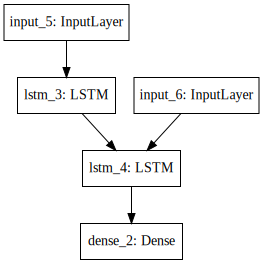

In [42]:
model.compile(loss      = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics   = ['accuracy'])
model.summary()

SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

In [43]:
batch_size = nwords # number of patterns...
epochs = 5000
history = model.fit([X,preY],
                    postY,
                    batch_size = batch_size,
                    epochs     = epochs,
                    verbose    = 0,
                    callbacks  = [TQDMNotebookCallback()])
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

HBox(children=(IntProgress(value=0, description='Training', max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=500), HTML(value='')))


500/500 [==============================] - 1s 2ms/step
Accuracy: 34.4125 %


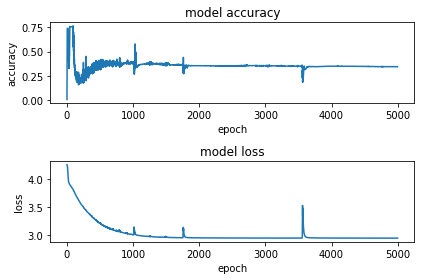

In [44]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [45]:
#Your encoder_model and decoder_model here!
encoder_model                                           = keras.Model(encoder_input, encoder_states)

decoder_state_input_h                                   = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c                                   = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input                                    = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                         initial_state = decoder_states_input)
decoder_states                                          = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output                                          = decoder_dense(decoder_hidden_output)
decoder_model                                           = keras.Model([decoder_input]  + decoder_states_input,
                                                                      [decoder_output] + decoder_states)

In [46]:
# Get the gestalt context for the input sequence(s)
i       = 0
context = encoder_model.predict(X[i:i+1,:,:])
# Prep a starting token...
token   = encode_seq('',stoi)[0].reshape(1,1,len(stoi))

In [47]:
# What should we see?
print('Input:', words[i])
print('Output:', words[i+1])

Input: It
Output: is


In [48]:
# Complete max cycles with the decoder
result = np.zeros([1,postY.shape[1],postY.shape[2]])
for x in range(postY.shape[1]):
    out,h,c = decoder_model.predict([token]+context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
decode_seq(result[0,:,:],itos)

'is'

In [49]:
# Iterate - teacher forcing through each line
for j in range(nwords):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[j:j+1,:,:])
    
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',words[j+1])
    print('Net:',decode_seq(result[0,:,:],itos))

Txt: is
Net: is
Txt: a
Net: ous
Txt: truth
Net: ings
Txt: universally
Net: e
Txt: acknowledged,
Net: acknowledged,
Txt: that
Net: that
Txt: a
Net: he
Txt: single
Net: ings
Txt: man
Net: man
Txt: in
Net: of
Txt: possession
Net: enering
Txt: of
Net: o
Txt: a
Net: uch
Txt: good
Net: ings
Txt: fortune,
Net: fortune,
Txt: must
Net: must
Txt: be
Net: il
Txt: in
Net: n
Txt: want
Net: enering
Txt: of
Net: to
Txt: a
Net: uch
Txt: wife.
Net: ings
Txt: However
Net: However
Txt: little
Net: little
Txt: known
Net: known
Txt: the
Net: the
Txt: feelings
Net: rsinglig
Txt: or
Net: or
Txt: views
Net: ingle?"
Txt: of
Net: of
Txt: such
Net: uch
Txt: a
Net: ares,
Txt: man
Net: ings
Txt: may
Net: of
Txt: be
Net: e
Txt: on
Net: n
Txt: his
Net: on
Txt: first
Net: ary
Txt: entering
Net: entering
Txt: a
Net: a
Txt: neighbourhood,
Net: ings
Txt: this
Net: this
Txt: truth
Net: truth
Txt: is
Net: e
Txt: so
Net: ous
Txt: well
Net: iglle
Txt: fixed
Net: fixed
Txt: in
Net: in
Txt: the
Net: enering
Txt: minds
Net: rs

In [50]:
# Iterate - but no teacher forcing past first line...
# Get the gestalt context for the input sequence
i       = 0
context = encoder_model.predict(X[i: i + 1, :, :])

for i in range(nwords):
    # Prep a starting token...
    token   = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result  = np.zeros([1, postY.shape[1], postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c       = decoder_model.predict([token] + context)
        token         = np.round(out)
        context       = [h, c]
        result[:, x, :] = token
    print('Txt:', words[i + 1])
    print('Net:', decode_seq(result[0, :, :], itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context = encoder_model.predict(result)

Txt: is
Net: is
Txt: a
Net: os
Txt: truth
Net: may
Txt: universally
Net: ime
Txt: acknowledged,
Net: of
Txt: that
Net: them,
Txt: a
Net: l
Txt: single
Net: and
Txt: man
Net: the
Txt: in
Net: is
Txt: possession
Net: os
Txt: of
Net: may
Txt: a
Net: ime
Txt: good
Net: of
Txt: fortune,
Net: them,
Txt: must
Net: l
Txt: be
Net: and
Txt: in
Net: the
Txt: want
Net: is
Txt: of
Net: os
Txt: a
Net: may
Txt: wife.
Net: ime
Txt: However
Net: of
Txt: little
Net: them,
Txt: known
Net: l
Txt: the
Net: and
Txt: feelings
Net: the
Txt: or
Net: is
Txt: views
Net: os
Txt: of
Net: may
Txt: such
Net: ime
Txt: a
Net: of
Txt: man
Net: them,
Txt: may
Net: l
Txt: be
Net: and
Txt: on
Net: the
Txt: his
Net: is
Txt: first
Net: os
Txt: entering
Net: may
Txt: a
Net: ime
Txt: neighbourhood,
Net: of
Txt: this
Net: them,
Txt: truth
Net: l
Txt: is
Net: and
Txt: so
Net: the
Txt: well
Net: is
Txt: fixed
Net: os
Txt: in
Net: may
Txt: the
Net: ime
Txt: minds
Net: of
Txt: of
Net: them,
Txt: the
Net: l
Txt: surrounding
Net: an

# Problem 3

The learning process in problem 2 took far more epochs than did that of problem 1, but it still took significantly less time to train to acheive a similar ability to perform. The accuracy for problem 2 was also notably lower than that of problem 1, but relatively good performance (i.e. mostly real words even without teacher forcing) was still attained.